# ConvAutoencodersMNIST
Hi everyone! Today we want to build a convolutional neural network which uses autoencoders to reconstruct digit from the MNIST dataset. We are going to use PyTorch as a framework once again. Keep in mind this is a **student-like** approach to autoencoders and should be taken accordingly.  Let's start by importing some libraries:

In [3]:
###Import libraries 
import os
import copy
import torch
import matplotlib.pyplot as plt
import random
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import numpy as np
import scipy.io as io
from torchvision.utils import make_grid
from sklearn import manifold
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2

ModuleNotFoundError: No module named 'cv2'

As every problem involving any form of machine learning, we start by analysing our input data. Once again, we are using images from the open-source *MNIST dataset*. Those are handwritten digit of dimension $28\times 28$ pixels. We download the data and we wrap it into a dataloader with a fixed batch size.

In [4]:
### Define paths
data_root_dir = '.\\'

#%% Create dataset + normalize data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(data_root_dir, train=True,  download=True, transform=train_transform)
train_data, validation_data = torch.utils.data.random_split(train_dataset, (50000, 10000))
test_dataset  = MNIST(data_root_dir, train=True, download=False, transform=test_transform)

### Define dataloader
train_dataloader = DataLoader(train_data, batch_size=512, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

Let's plot some samples to see how our images appears.

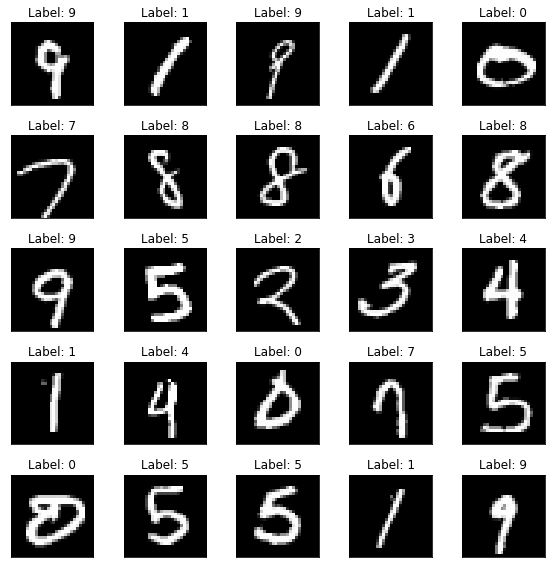

In [5]:
### Plot some sample
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

Let's now define the structure of our network. The network structure is quite complex, so I'll go over it gradually:
### Convolutional encoder
In this first section of the network, we apply a mix of convolutions, pooling and activation functions with the scope of generating *feature maps*, which are an optimal compressed representation of the input image. We start by applying two convolution layers, each one followed by a *ReLU* function. Then, we apply *max pooling* to the feature maps to reduce their space even further. Max pooling maps multiple value into their maximum value. When we do max pooling we maintain the same depth but we reduce the resolution of the features. Something we might be aware of when designing a convolutional network are some parameters that needs to be tweaked: 
1. the *filter* (or kernel) size is the "receptive field" of the kernel. Note that larger kernel might overlook at the features, while smaller kernel could provide too much information;
2. the *stride*, which is the size of the steps the convolutional kernel take over the image;
3. the *zero padding* consists in layers of zero-valued inputs surrounding the image. This is used to preserve the original image size. 

Those parameters determine the size of the output feature map. In particular, the output can be calculated as:

$$O=\frac{W-K+2P}{S}+1$$

where $W$ is the input size, $K$ is the kernel size, $P$ is the padding and $S$ is the stride.
### Linear encoder
Here we pass the image obtained trough the previous encoding into a standard NN architecture. This consists of one hidden layers (followed by a ReLU) and one output layers. In particular, the size of the output layer is called *latent space*: this capture the structure of the data trough feature vectors. Features that look similar are clustered together in the latent space. This parameter will be better explored later.
### Linear and convolutional decoders
By using the features obtained from the encoding, we want to obtain the closest match to the actual input. The decoder has the same structure of the encoder (both linear and convolutional) but in the opposite direction. To get our image back, we need to apply deconvolution, once again setting kernel size, stride and padding. The size of the output can be calculated as:

$$O=W\times S -2P+(dilation)(K-1)+P_{out}+1$$

where $W$ is the input size, $K$ is the kernel size, $P$ is the input padding, $P_{out}$ is the output padding and $S$ is the stride. $dilation$ controls the spacing between the kernel points.
In the end, we'll obtain once again a $28\times 28$ pixels image which we can compare to the original.

In [6]:
### Convolutional Autoencoder network. Note that:
#   torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding) – applies convolution
#   torch.nn.MaxPool2d(kernel_size, stride, padding) – applies max pooling
class AutoencoderNet(nn.Module):
    
    def __init__(self, encoded_space_dim):
        
        super(AutoencoderNet, self).__init__()
        
        ### Encoder 
        self.encoder_cnn = nn.Sequential(
            
            # input size (1,28,28) -> output size (16,10,10)
            nn.Conv2d(1, 16, 3, stride=3, padding=1),
            # apply activation function
            nn.ReLU(True),
            # input size (16, 10, 10) -> output size (32, 5, 5)
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            # apply activation function
            nn.ReLU(True),
            # input size (32, 5, 5) -> output size (32, 4, 4)
            nn.MaxPool2d(2, stride=1),
        )
        
        ## fully connected linear layers
        self.encoder_lin = nn.Sequential(
            
            # 512 input features, 64 output features 
            nn.Linear(32 * 4 * 4, 64),
            # apply activation function
            nn.ReLU(True),
            # 64 input features, varying latent space output size 
            nn.Linear(64, encoded_space_dim)
        )
        
        ### Decoder
        self.decoder_lin = nn.Sequential(
            # varying latent space input size, 64 output size 
            nn.Linear(encoded_space_dim, 64),
            # apply activation function
            nn.ReLU(True),
            # 64 input features, 512 output features
            nn.Linear(64, 32 * 4 * 4),
            # apply activation function
            nn.ReLU(True)
        )
        # reconstruct the data trough transpose layers
        self.decoder_conv = nn.Sequential(    
            # input size (32, 4, 4) -> output size (16, 8, 8)
            nn.ConvTranspose2d(32, 16, 3, stride=2,  padding=1, output_padding=1),
            # apply activation function
            nn.ReLU(True),
            # input size (16, 8, 8) -> output size (8, 14, 14)
            nn.ConvTranspose2d(16, 8, 3, stride=2,  padding=2, output_padding=1),
             # apply activation function
            nn.ReLU(True),
            # input size (8, 14, 14) -> output size (1, 28, 28)
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    # forward propagation
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = x.view([x.size(0), -1])
        # Apply linear layers
        x = self.encoder_lin(x)
        return x
    
    def decode(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Reshape
        x = x.view([-1, 32, 4, 4])
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

Next there are a lot of methods that we're going to use later on. Just come back to them later when we're calling them. If necessary, you will find the explanation below with the call to the method.

In [105]:
# Scatter with images instead of points
def imscatter(x, y, ax, imageData, zoom):
    images = []
    for i in range(len(x)):
        x0, y0 = x[i], y[i]
        # Convert to image
        img = imageData[i]*255.
        img = img.astype(np.uint8).reshape([28,28])
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        # Note: OpenCV uses BGR and plt uses RGB
        image = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
        images.append(ax.add_artist(ab))
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

# Show dataset images with T-sne projection of latent space encoding
def computeTSNEProjectionOfLatentSpace(X, model, display=True):
    # Compute latent space representation
    print("Computing latent space projection...")
    with torch.no_grad():
        X_encoded = model.encode(X)
    # Compute t-SNE embedding of latent space
    print("Computing t-SNE embedding...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X_encoded)

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(figsize=(20,10))
        imscatter(X_tsne[:, 0], X_tsne[:, 1], imageData=np.asarray(X), ax=ax, zoom=0.5)
        plt.show()
    else:
        return X_tsne
    
# Plot the losses over the number of epochs
def training_loss_plot(train_loss, test_loss):

    plt.close('all')
    plt.figure(figsize=(8,6))
    plt.semilogy(train_loss, label='Train loss')
    plt.semilogy(test_loss, label='Validation loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

# get the activation maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

## occlude an image with a dimxdim square placed randomly over the image
def random_occlusion(image, batch, dim=6):
    
    # random edges of the occlusion square
    idx = np.random.randint(0, 28-dim)
    idy = np.random.randint(0, 28-dim)
    
    # set the pixels to 0.0 (black)
    if batch: # set for batch of images
        for img in image:
            for i in range(idx, idx+dim):
                for j in range(idy, idy+dim):
                    img[i][j] = 0.0
    else: # set for only one img
        for i in range(idx, idx+dim):
                for j in range(idy, idy+dim):
                    image[i][j] = 0.0
            
    return image

## Apply Gaussian noise based on a noise intensity factor
def gaussian_noise(image, noise_factor):
    
    # torch.randn returns random values from a normal with mean 0 and variance 1 -> Gaussian noise!
    noisy_img = image + noise_factor * torch.randn(*image.shape)
    #clip the image
    noisy_img = np.clip(noisy_img, 0., 1.)
    
    return noisy_img

To find a good number of epochs and a good learning rate, we excute a random search. Note that this might take a lot of time to excute. (by default, random search doesn't occurs when using the notebook)

In [8]:
## Random search over learning rate and the numbers of epochs
## Long time to process, excute only when researching hyperparameters!!!
def rand_search(model, test_dataloader, num_iters, weight_dec = True):
    
    # initialize some params
    loss_store, lr_store, epoch_store, encoded_dim = [], [], [], []
    best_lr, best_epochs, best = 0, 0, 0

    for i in range(num_iters):  
    
        ### Define a loss function
        loss_fn = torch.nn.MSELoss()
        
        #Set random parameters
        rand_lr = random.randint(1,5)*(10**(-random.randint(2,6)))
        rand_epoch = (random.randint(10,60))
        rand_encoded_space_dim = 10
        # Set lr
        if weight_dec: optim = torch.optim.Adam(model.parameters(), lr=rand_lr, weight_decay=1e-5) #set LR
        else: optim = torch.optim.Adam(model.parameters(), lr=rand_lr)
        
        #Initialize the network
        model = AutoencoderNet(encoded_space_dim=rand_encoded_space_dim)
        
        print("iteration: ", i, " lr: ", rand_lr, "and #epoch: ", rand_epoch) 
        #Compute the training
        for epoch in range(rand_epoch):
            train_epoch(model,  dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim)
            loss = test_epoch(model, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim) 
        ##Store the parameters
        loss_store.append(loss)
        lr_store.append(rand_lr)
        epoch_store.append(rand_epoch)
    
        ## Update the best parameters
        if(i == 0): 
            best = loss
            print("The best loss so far is: ", best, " with lr: ", rand_lr, "and #epoch: ", rand_epoch)
        elif (loss < best):
            best_lr = rand_lr
            best_epochs = rand_epoch
            best = loss
            print("The best loss so far is: ", best, " with lr: ", rand_lr, "and #epoch: ", rand_epoch)
            
    print("The best loss is: ", best, " with lr: ", rand_lr, "and #epoch: ", rand_epoch)
    return loss_store, lr_store, epoch_store

## numbers of conbinations of hyperparameters to try
num_iters = 10
search = False
if search: loss_store, lr_store, epoch_store = rand_search(model, train_loader, num_iters)

Those are the methods which regulate training and testing. Pretty standard stuff.

In [9]:
### Training function
def train_epoch(net, dataloader, loss_fn, optimizer):
    
    # Tell it we are in training mode
    net.train()
    train_loss = []
    for images in dataloader:
        
        # Extract data and move tensors to the selected device
        image_batch = images[0].to(device)
        
        # Backward pass
        optim.zero_grad()
        
        # Forward pass
        output = net(image_batch)
        
        # reshape images in a suitable way for the loss calculation
        image_batch = image_batch.reshape([-1,1, 28, 28])

        ## loss calculation
        loss = loss_fn(output, image_batch)
        
        ## backward pass
        loss.backward()
        
        ## weight optimization
        optimizer.step()
        
        train_loss.append(loss.data)
    return np.mean(train_loss)


### Testing function
def test_epoch(net, dataloader, loss_fn, optimizer, corrupt, occlude):
    
    # Validation
    net.eval() # Evaluation mode (e.g. disable dropout)
    
    with torch.no_grad(): # No need to track the gradients
        
        conc_out = torch.Tensor().float()
        conc_label = torch.Tensor().float()
        
        for images in dataloader:
            
            # Extract data and move tensors to the selected device
            image_batch = images[0].to(device)
            
            # apply noise/occlude if needed
            if corrupt: image_batch = gaussian_noise(image_batch, 0.3)
            if occlude: image_batch = random_occlusion(image_batch.squeeze(), batch = True).unsqueeze(1)
                
            # Forward pass
            out = net(image_batch)
            # reshape
            image_batch = image_batch.reshape([-1,1, 28, 28])
            
            # Concatenate with previous outputs
            conc_out = torch.cat([conc_out, out.cpu()])
            conc_label = torch.cat([conc_label, image_batch.cpu()]) 
            
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

Next, we initialize the network. The loss function used is the *Mean Squared Error* loss. We also implement weight decay on our optimizer to better converge on a local minima.

In [10]:
### Initialize the network
encoded_space_dim = 20
model = AutoencoderNet(encoded_space_dim=encoded_space_dim)

### Define loss function
loss_fn = torch.nn.MSELoss()

### Define optimizer
lr = 0.005 # Learning rate
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

### If cuda is available set the device to GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
# Move all the network parameters to the selected device (if they are already on that device nothing happens)
model.to(device)

AutoencoderNet(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_lin): Sequential(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=20, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=512, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))

The train of the network is standard stuff: we reset the gradients, compute the output, calculate the loss, perform back-propagation and optimize the weights. The loss is computed by doing the MSE between the actual and reconstructed input. To be sure the model doesn't overfit, I also used *early-stopping* in the form of a check over the mean of the past validation error of the last 15 epochs. If the mean is lower than our current validation error, then we're starting to overfit our data and we need to stop learning. Both the encoder and decoder weights will be updated simultaneously with the objective of lowering the reconstruction error. During the training we also plot some reconstructed images in order to see how the model is learning to reconstruct over time (not active by default). 

In [ ]:
### Training cycle
num_epochs = 60 
plot = False
val_losses, train_losses = [], []

# training and validation 
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training
    train_loss = train_epoch(model, dataloader=train_loader, loss_fn=loss_fn, optimizer=optim)
    ### Validation
    val_loss = test_epoch(model, dataloader=validation_loader, loss_fn=loss_fn, optimizer=optim, corrupt=False, occlude=False) 
    val_losses.append(val_loss)
    train_losses.append(train_loss) 
    
    # Print Validation loss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))
        
    if epoch % 1 == 0 and plot: #once every x epochs
        ### Plot progress
        model.eval()
        with torch.no_grad():
             rec_img  = model(test_dataset[25][0].unsqueeze(0))
        fig, axs = plt.subplots(1, 2, figsize=(6,3))
        axs[0].imshow(x_validation[2].squeeze(0).cpu().numpy(), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        # Save figures
        os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
        plt.savefig('autoencoder_progress_%d_features/epoch_%d.png' % (encoded_space_dim, epoch + 1))
        plt.pause(0.1)
        #plt.show()
        #plt.close()
        
        # early stopping if validation loss doesn't improves over the last 8 epochs
        if epoch > 1 and np.mean(val_losses[epoch-15:epoch-1]) < val_loss: break

We've trained our network successfully. We can now save our model for further trials before starting to examine the output.

In [ ]:
## Save the model of the network in the folder of the data
torch.save(model.state_dict(), '.\\'+ 'netModel.txt')

To check how the training and the validation performed, we plot the losses over the number of epochs by calling the corresponding method.

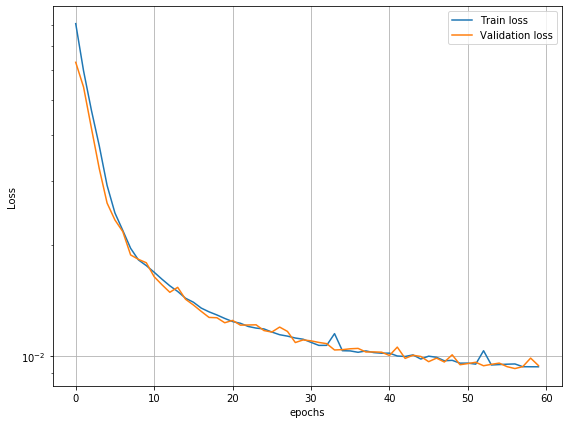

In [12]:
# plot the losses over the epochs
training_loss_plot(train_losses, val_losses)

Seems like our network is doing alright. Let's see if the network can however generalize well enough with unseen data.

In [15]:
# test the network over the unseen test_set
test_loss = []
test_loss = test_epoch(model, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim, corrupt=False, occlude=False)

print("The reconstruction error over the test set is ", test_loss)

The reconstruction error over the test set is  tensor(0.0093)


All good!! Let's move forward. I've promised you before that I would'have explained more in detail the latent size. The latent size of our dense layer is the number of features we are extracting from our encoded image. Therefore, more features will surely lead to better performances. However, a large number of features might lead to an overfit over our training datas, making our model unable to generalize efficiently. It also enforce complexity that might be unnecessary. As an example, look at how the model reconstruct with a latent size of $3$:

![SegmentLocal](Reconstruction_3size.gif "segment")

while with a latent size of $150$ we get:

![SegmentLocal](Reconstruction_150size.gif "segment")

Let's move on with the output analysis. By the way, curious of how kernel looks in our first convolutional Network?

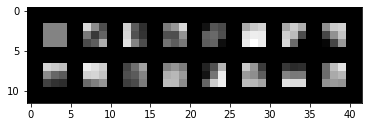

In [51]:
# extract one image to use for actvations and noise/occlusion trials
img = test_dataset[25][0].unsqueeze(0)

## visualize kernels of the first CNN
kernels = model.encoder_cnn[0].weight.detach().clone() 
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
kern = make_grid(kernels)
plt.imshow(kern.permute(1, 2, 0))

Ah, sweet little $3\times 3$ kernels. Now we examine the activation maps of a digit passing trough the various encoding layer. The first one gives us:

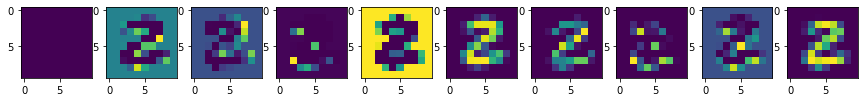

In [52]:
## Visualize activation function of the first convolutional encoder layer 
model.encoder_cnn[0].register_forward_hook(get_activation('ext_conv1'))

output = model(img)
act = activation['ext_conv1'].squeeze()

num_plot = 10
fig, axarr = plt.subplots(1, 10, figsize=(15,5))
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].imshow(act[idx])

The second one gives:

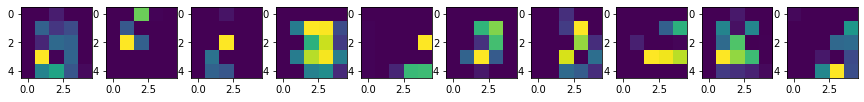

In [53]:
## Visualize activation function of the second convolutional encoder layer 

model.encoder_cnn[2].register_forward_hook(get_activation('ext_conv2'))

output = model(img)
act = activation['ext_conv2'].squeeze()

num_plot = 10
fig, axarr = plt.subplots(1, 10, figsize=(15,5))
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].imshow(act[idx])

And finally after applying Max pooling we obtain:

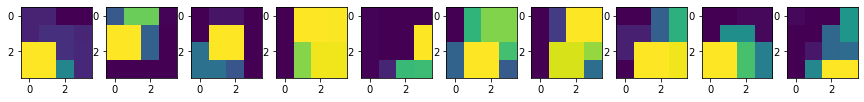

In [54]:
## Visualize activation function of the third convolutional encoder layer 

model.encoder_cnn[4].register_forward_hook(get_activation('ext_conv4'))

output = model(img)

activ = activation['ext_conv4'].squeeze()

num_plot = 10
fig, axarr = plt.subplots(1, 10, figsize=(15,5))
for idx in range(min(activ.size(0), num_plot)):
    axarr[idx].imshow(activ[idx])

Here we can see where happens the maximum activation of a certain kernel trough the encoding phase. Also appears clear the effect of the encoding by looking at the structure of the image. The kernels that doesn't shown anything are probably looking for feature that are not in the current image.  

To further look into the reconstruction capabilities of the model, we try to apply some noise and random occlusions to the image. We can see different intensity of Gaussian noise applied to the image and the corresponding reconstructions below. For low level of noise, the model is still able to recover an image that resemble the original. After increasing a bit the intensity, our network is however unable to reshape the image and fail. Corrupting images could be also done prior the training. This way, we can produce a *denoiser* neural network. 

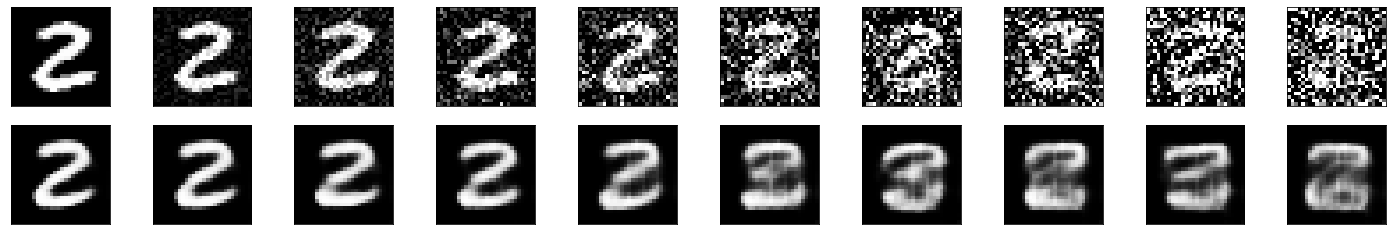

In [58]:
## Plot gaussian noise with various intensity
corr_imgs, rec_imgs  = [], [],

# gradually apply noise and reconstruct images
for i in range (0,10):
    
    imgc = test_dataset[25][0].unsqueeze(0)
    corr_imgs.append(gaussian_noise(imgc, 0.1*i)) 
    
    model.eval()
    with torch.no_grad():
        rec_imgs.append(model(corr_imgs[i]))
    
# plot the corrupted input image and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for corr_imgs, row in zip([corr_imgs, rec_imgs], axes):
    for img, ax in zip(corr_imgs, row):
        
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

By applying random occlusions to the image, we can see which features our model is really paying attention to. This can be seen in the plot of the cells below. If the reconstructions is bad after covering a section of the image, then there was a feature describing that section which was really important to reconstruct correctly the digit. Sometimes we can instead just cover a part and having almost no loss in the overall reconstruction.

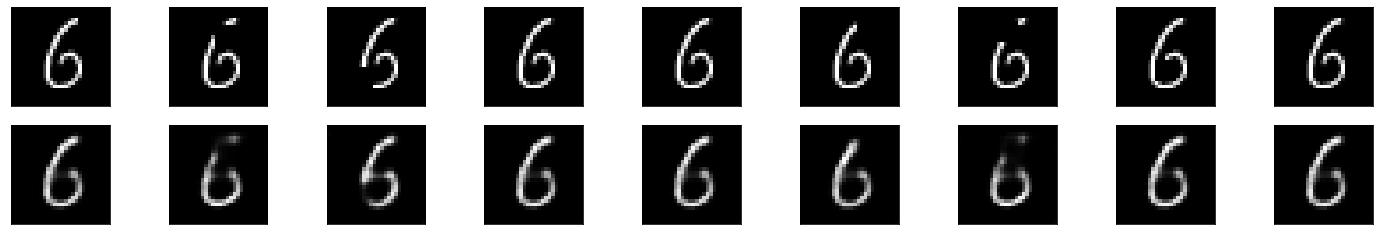

In [160]:
img_occl, rec_imgs = [], []

# occlude 10 images and reconstruct images
for i in range (1,10):
    
    img0 = test_dataset[18][0].unsqueeze(0)#copy.deepcopy(img) # reference passwould occlude the original image
    img_occl.append(random_occlusion(img0.squeeze(), batch=False)) 
    
    model.eval()
    with torch.no_grad():
        rec_imgs.append(model(img_occl[i-1].unsqueeze(0).unsqueeze(1)))


# plot the occluded input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=9, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for img_occl, row in zip([img_occl, rec_imgs], axes):
    for img, ax in zip(img_occl, row):
        
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Finally, for the big finale, we can see look at our model is dividing the data by plotting the embeddings in the dense layer. To do this, we consider $3000$ samples from the training set and we make them pass trough the encoding section (both convolutional and linear) of our model. Then we compute the *t-distributed Stochastic Neighbour Embedding*. TSNE converts similarities between data points to joint probabilities and tries to minimize the KL divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. Here, we can see how, trough unsupervised learning, our model is learning to cluster together the digits. We can notice how numbers like $3$ and $8$ are closer than numbers like $7$ or $1$.  Seems like the network has learned quite well to recognize the digits using the features in the latent space. (The reshape part is due to incompatibility between the tsne method and multidimensional tensors)

Computing latent space projection...
Computing t-SNE embedding...
Plotting t-SNE visualization...


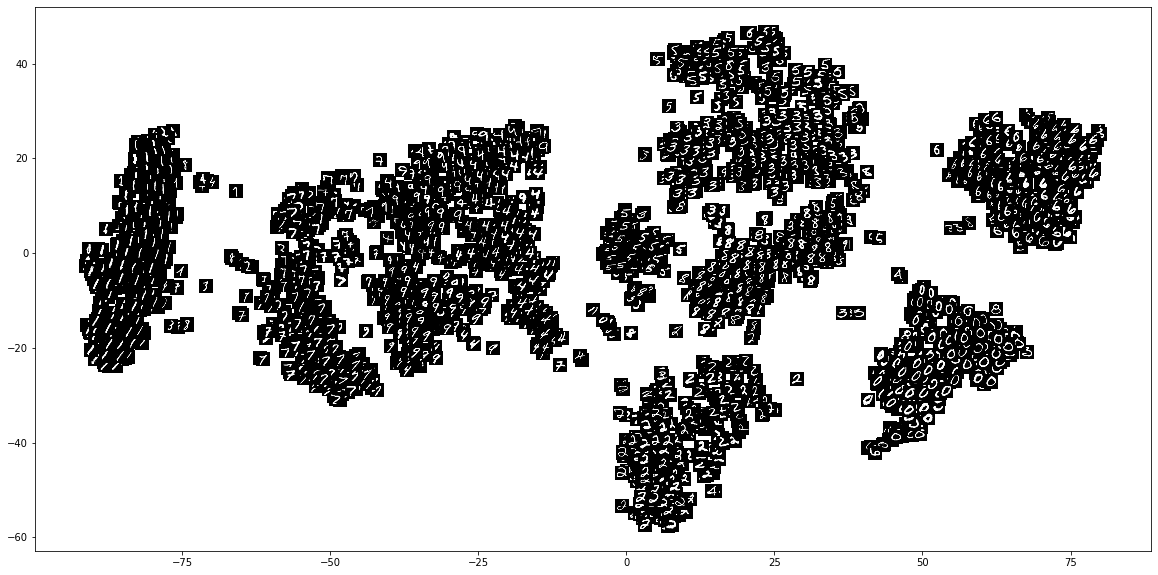

In [216]:
tsne_set = []
for i, images in enumerate(test_dataset):   
    # Extract data and reshape to numpy
    tsne_set.append(images[0].numpy())
    if i == 3000: break
tsne_set = torch.FloatTensor(tsne_set) #reshape to tensor

#plot the tsne of the embeddings
computeTSNEProjectionOfLatentSpace(tsne_set, model) 